In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


['API_time.PNG', 'Capture.PNG', 'Cat Dog Image Classification nut.ipynb', 'data', 'DCtrain', 'desktop.ini', 'etc', 'Facebook Sentimental Analysis.ipynb', 'Kaggle IEEE fraud detection', 'nut.ipynb', 'test2014', 'test2014 - Copy', 'thai-named-entity-recognition-data-master', 'Thai_NER', 'WS Stuff Done', 'WSA']


Import cat, dog , and others picture and label it

In [2]:
filenames = os.listdir("./Train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("dog")
    elif category == 'cat':
        categories.append("cat")
    else:
        categories.append('others')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

Import picture other than cat and dog and labeled it others

In [3]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [4]:
df.tail()

,filename,category
42691,dog.9995.jpg,dog
42692,dog.9996.jpg,dog
42693,dog.9997.jpg,dog
42694,dog.9998.jpg,dog
42695,dog.9999.jpg,dog


Explore the data a bit. The data is balance and clean

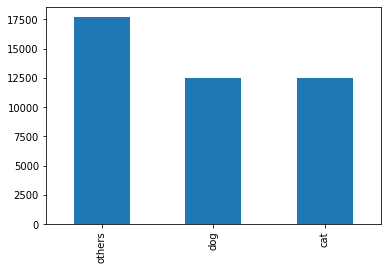

In [5]:
df['category'].value_counts().plot.bar()

Sanity Check

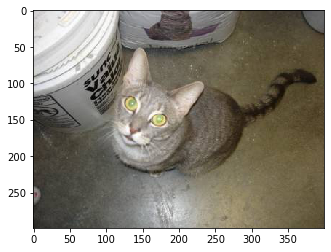

In [6]:
sample = random.choice(filenames)
image = load_img("./Train/"+sample)
plt.imshow(image)

Let's prepare the data

Split the data to train and validation set

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

See if data is unbalance or not after the split

In [8]:
train_df['category'].value_counts()

others    14181
dog       10026
cat        9949
Name: category, dtype: int64

In [9]:
validate_df['category'].value_counts()

others    3515
cat       2551
dog       2474
Name: category, dtype: int64

Since the inception of Alexnet CNN has been staple of Image Processing ever since, so CNN will be used specifically VGG 16 architecture.
Built a CNN model using VGG16 

In [10]:
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D, BatchNormalization
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 20
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
#x = GlobalMaxPooling2D()(last_output)
# Flatten the output layer to 2 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add batch normalization
x = BatchNormalization()(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)

Generate image by rotation flip, shear, etc. To increase the accuracy of the ANN

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./Train", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 34156 validated image filenames belonging to 3 classes.


Do the same with validation data

In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./Train", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 8540 validated image filenames belonging to 3 classes.


Set learning rate, early stop for the model

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


Run the model

In [14]:
# fine-tune the model
from keras.callbacks import ModelCheckpoint
filepath="Image_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [earlystop, learning_rate_reduction, checkpoint]
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
2134/2134 [==============================] - 542s 254ms/step - loss: 0.4531 - acc: 0.8497 - val_loss: 0.2365 - val_acc: 0.9250

Epoch 00001: val_acc improved from -inf to 0.92495, saving model to Image_best_weights.01-0.9250.hdf5
Epoch 2/20
2134/2134 [==============================] - 511s 240ms/step - loss: 0.2944 - acc: 0.9111 - val_loss: 0.1983 - val_acc: 0.9375

Epoch 00002: val_acc improved from 0.92495 to 0.93747, saving model to Image_best_weights.02-0.9375.hdf5
Epoch 3/20
2134/2134 [==============================] - 514s 241ms/step - loss: 0.2538 - acc: 0.9220 - val_loss: 0.1770 - val_acc: 0.9415

Epoch 00003: val_acc improved from 0.93747 to 0.94146, saving model to Image_best_weights.03-0.9415.hdf5
Epoch 4/20
2134/2134 [==============================] - 515s 241ms/step - loss: 0.2306 - acc: 0.9312 - val_loss: 0.1765 - val_acc: 0.9429

Epoch 

Visualize the acc and loss of the model

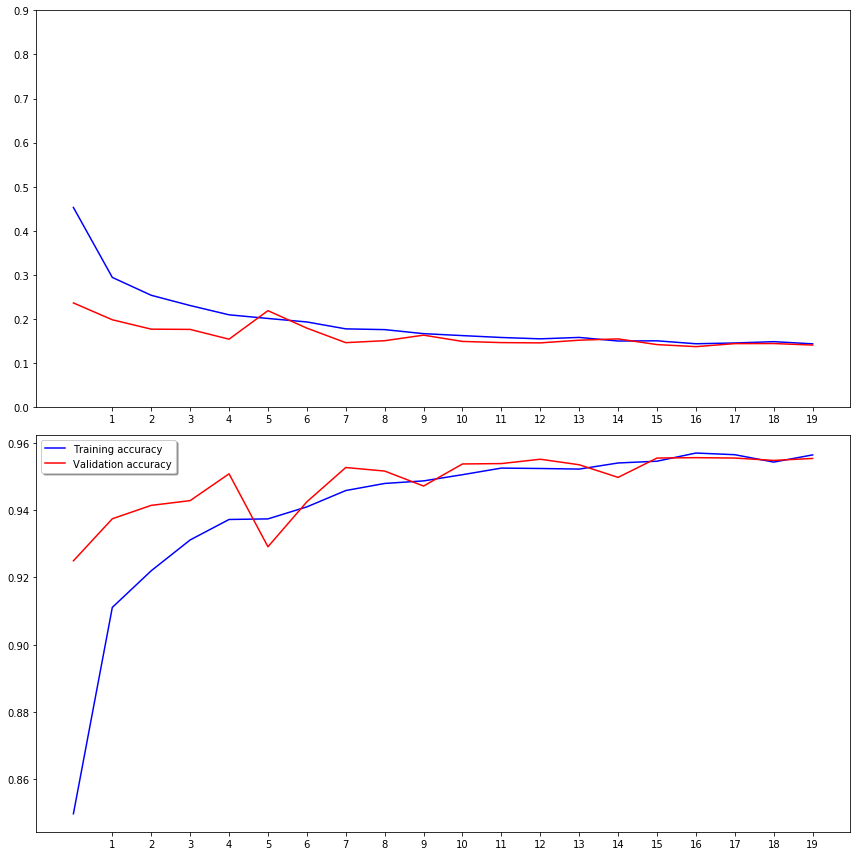

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare data of test file

Load the data

In [16]:
test_filenames = os.listdir("./data")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Generate image for test set

In [17]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./data", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 2422 validated image filenames.


Predict the data using trained model

In [18]:
import time
start = time.time()
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
end = time.time()


In [19]:
print(end - start)

34.649290323257446


Set the highest prob to be that category

In [20]:
test_df['category'] = np.argmax(predict, axis=-1)

Map the label to the picture to better visualize it

In [21]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

Explore the predicted data

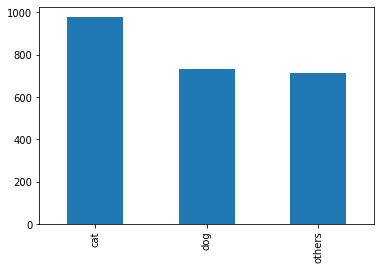

In [22]:
test_df['category'].value_counts().plot.bar()

In [23]:
test_df['category'].value_counts()

cat       978
dog       732
others    712
Name: category, dtype: int64

Visualize some of the result

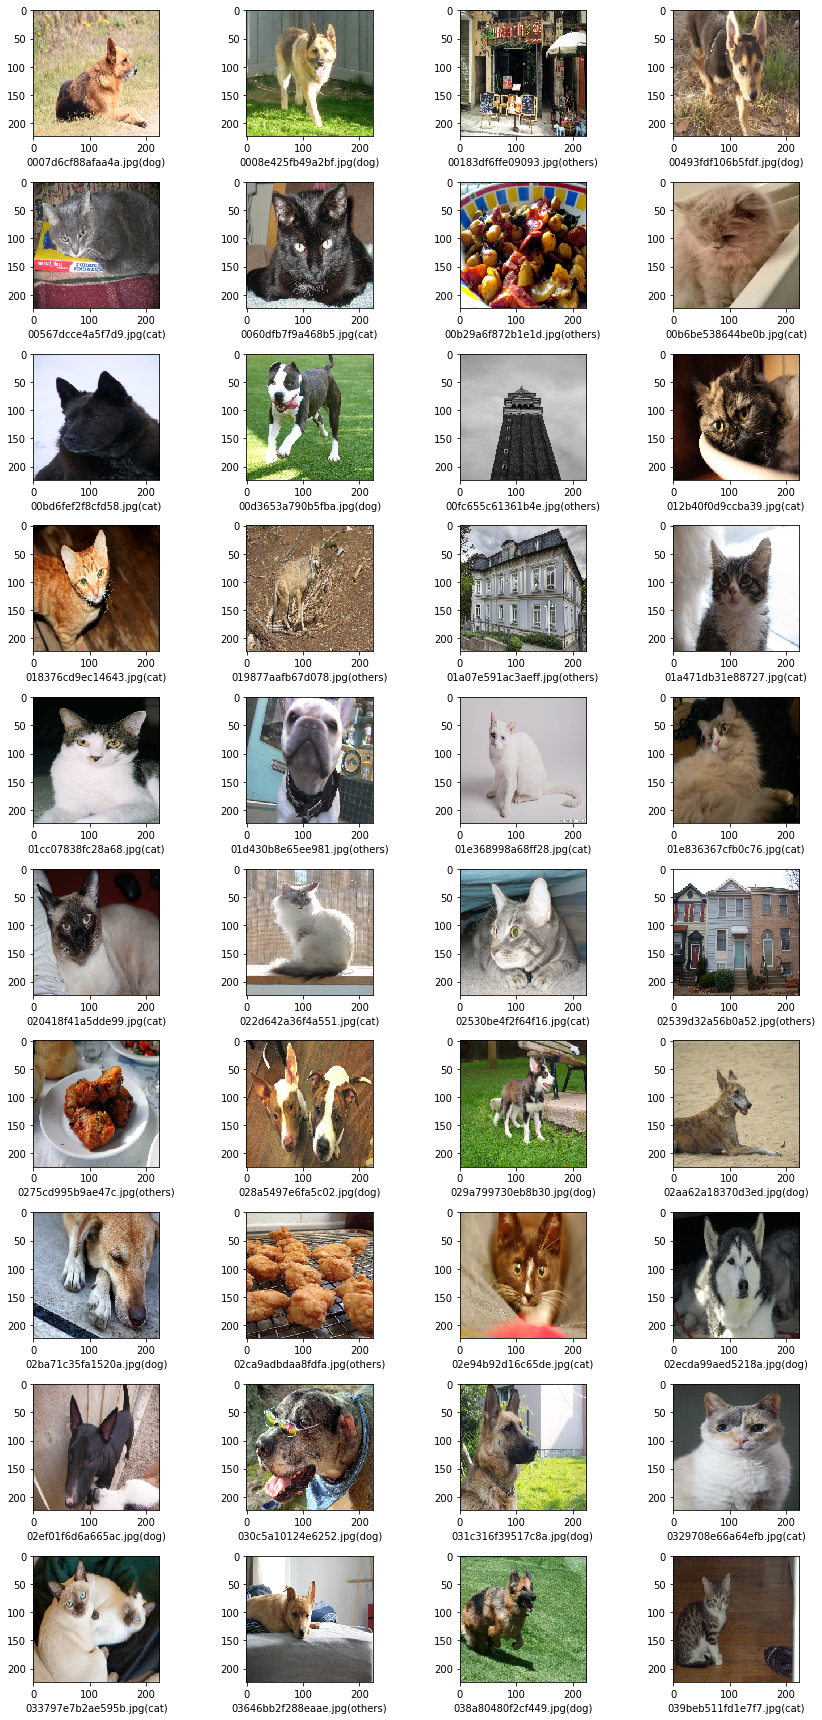

In [24]:
sample_test = test_df.head(40)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Desktop/data/"+filename, target_size=(image_size, image_size))
    plt.subplot(10, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Export the prediction to csv

In [25]:
final_df = test_df.copy()
final_df['id'] = final_df['filename'].str.split('.').str[0]
final_df['label'] = final_df['category']
final_df.drop(['filename', 'category'], axis=1, inplace=True)
final_df.to_csv("Desktop\Dog_Cat_Others.csv", index=False)